# 📝 Exercise M1.05

The goal of this exercise is to evaluate the impact of feature preprocessing
on a pipeline that uses a decision-tree-based classifier instead of a logistic
regression.

- The first question is to empirically evaluate whether scaling numerical
  features is helpful or not;
- The second question is to evaluate whether it is empirically better (both
  from a computational and a statistical perspective) to use integer coded or
  one-hot encoded categories.

In [16]:
import pandas as pd

adult_census = pd.read_csv("../datasets/adult-census.csv")

In [17]:
target_name = "class"
target = adult_census[target_name]
data = adult_census.drop(columns=[target_name, "education-num"])

As in the previous notebooks, we use the utility `make_column_selector`
to select only columns with a specific data type. Besides, we list in
advance all categories for the categorical columns.

In [18]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)
print('cat cols: %s\n   num_cols: %s'%(categorical_columns, numerical_columns))

cat cols: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
   num_cols: ['age', 'capital-gain', 'capital-loss', 'hours-per-week']


<AxesSubplot:>

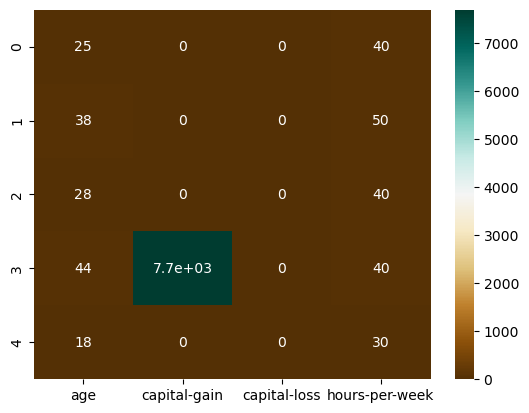

In [19]:
#data.corr()
import seaborn as sns
sns.heatmap(data[numerical_columns].head(), annot=True, cmap='BrBG')

## Reference pipeline (no numerical scaling and integer-coded categories)

First let's time the pipeline we used in the main notebook to serve as a
reference:

In [20]:
import time

from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from joblib import parallel_backend

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)
preprocessor = ColumnTransformer([
    ('categorical', categorical_preprocessor, categorical_columns)],
    remainder="passthrough")

model = make_pipeline(preprocessor, HistGradientBoostingClassifier())



In [21]:
def run_mod(model):
    start = time.time()
    with parallel_backend('threading', n_jobs=4):
        cv_results = cross_validate(model, data, target)
    elapsed_time = time.time() - start

    scores = cv_results["test_score"]

    print("The mean cross-validation accuracy is: "
          f"{scores.mean():.3f} ± {scores.std():.3f} "
          f"with a fitting time of {elapsed_time:.3f}")

In [22]:
run_mod(model)
del model

The mean cross-validation accuracy is: 0.873 ± 0.002 with a fitting time of 6.611


## Scaling numerical features

Let's write a similar pipeline that also scales the numerical features using
`StandardScaler` (or similar):

In [23]:
from sklearn.preprocessing import StandardScaler
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

numerical_preprocessor = StandardScaler()
preprocessor = ColumnTransformer([
    ('ordinal-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

model = make_pipeline(preprocessor, HistGradientBoostingClassifier())

In [24]:
run_mod(model)
del model

The mean cross-validation accuracy is: 0.873 ± 0.003 with a fitting time of 6.615


## One-hot encoding of categorical variables

We observed that integer coding of categorical variables can be very
detrimental for linear models. However, it does not seem to be the case for
`HistGradientBoostingClassifier` models, as the cross-validation score
of the reference pipeline with `OrdinalEncoder` is reasonably good.

Let's see if we can get an even better accuracy with `OneHotEncoder`.

Hint: `HistGradientBoostingClassifier` does not yet support sparse input
data. You might want to use
`OneHotEncoder(handle_unknown="ignore", sparse=False)` to force the use of a
dense representation as a workaround.

In [25]:
from sklearn.preprocessing import OneHotEncoder
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse=False)
preprocessor = ColumnTransformer([
    ('oneHot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

model = make_pipeline(preprocessor, HistGradientBoostingClassifier())

In [26]:
run_mod(model)

The mean cross-validation accuracy is: 0.873 ± 0.003 with a fitting time of 16.125
